In [1]:
import definitions as df
import data_manipulation as dm
import sql_def as sql
import os
import numpy as np
import matplotlib.pyplot as plt
import plots
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import math
import torch.nn.functional as F

Grabing the data from SQL dataset

In [2]:
path_to_database = r"/Users/rr/Desktop/diff_transformers/project/data"
path_to_code = r"/Users/rr/Desktop/diff_transformers/project"
os.chdir(path_to_database)
track_from_sql =  sql.data_from_sql("database.db", "SELECT * FROM TRACKMATEDATA")
os.chdir(path_to_code)
track_with_frame = df.separate_trajectories(track_from_sql)
trajectories1 = df.separate_data(track_with_frame, False)
trajectories = []
for temp in trajectories1:
    f2 = []
    c = 1
    for t1 in temp:
        f2.append(t1)
        c += 1
        if c == 10:
            break
    trajectories.append(f2)
trajectories

[[(424.4435, 1711.9775),
  (402.177, 1711.2914),
  (424.0598, 1709.0296),
  (430.233, 1703.6202),
  (437.3247, 1694.1591),
  (433.2782, 1687.5521),
  (432.7909, 1690.6145),
  (449.0688, 1695.5747),
  (448.6298, 1692.6731)],
 [(199.5516, 1852.7813),
  (202.5402, 1838.6909),
  (203.0731, 1835.3324),
  (207.5109, 1830.2404),
  (219.6977, 1823.5929),
  (216.0012, 1813.2095),
  (212.2338, 1813.4252),
  (214.5405, 1817.368),
  (214.5307, 1813.6753)],
 [(358.6978, 1727.2507),
  (355.0077, 1734.5474),
  (352.017, 1744.1678),
  (352.8249, 1744.8427),
  (353.6329, 1745.5176),
  (354.4409, 1746.1925),
  (355.2488, 1746.8675),
  (356.0568, 1747.5424),
  (356.8648, 1748.2173)],
 [(341.8735, 1742.8685),
  (332.3119, 1753.2677),
  (330.5376, 1747.3787),
  (331.985, 1749.2015),
  (333.4325, 1751.0244),
  (334.88, 1752.8472),
  (344.7104, 1749.7057),
  (335.2146, 1744.263),
  (356.7546, 1733.8491)],
 [(238.636, 1607.6895),
  (241.3557, 1600.0849),
  (232.1582, 1601.2803),
  (230.3202, 1598.5422),
  (23

Making Fake data

In [3]:
total_size = 12000
max_x = 1000
max_y = 1000
min_x = 0
min_y = 0
track_len = 20

trajectories = dm.create_synthetic(total_size, max_x, max_y, min_x, min_y, track_len)

In [4]:
train_norm, test_norm = df.split_test_train(trajectories)
train, min_x, min_y, range_x, range_y = df.normalize_data(train_norm)
test, min_x, min_y, range_x, range_y = df.normalize_data(test_norm, min_x, min_y, range_x, range_y)
train_data, train_masked_point = df.mask_point_at_index(train, 6)
test_data, test_masked_point = df.mask_point_at_index(test, 6)

print(len(train_data))
print(len(test_masked_point))

10800
1200


In [5]:
src_data_tensor, tgt_data_tensor, src_masks_tensor = df.prepare_data_for_transformer(train_data, train_masked_point)

## DEBUG
print(src_data_tensor)
print("src_data_tensor shape:", src_data_tensor.shape)
print("tgt_data_tensor shape:", tgt_data_tensor.shape)
print("src_masks_tensor shape:", src_masks_tensor.shape)

hello
tensor([[[0.8550, 0.4345],
         [0.8601, 0.4345],
         [0.8652, 0.4345],
         ...,
         [0.9417, 0.4345],
         [0.9468, 0.4345],
         [0.9519, 0.4345]],

        [[0.6160, 0.5527],
         [0.6159, 0.5534],
         [0.6158, 0.5541],
         ...,
         [0.6137, 0.5651],
         [0.6135, 0.5658],
         [0.6134, 0.5665]],

        [[0.3829, 0.7474],
         [0.3894, 0.7474],
         [0.3960, 0.7474],
         ...,
         [0.4944, 0.7474],
         [0.5009, 0.7474],
         [0.5075, 0.7474]],

        ...,

        [[0.5111, 0.5140],
         [0.5075, 0.5133],
         [0.5040, 0.5126],
         ...,
         [0.4503, 0.5020],
         [0.4467, 0.5012],
         [0.4432, 0.5005]],

        [[0.8390, 0.7295],
         [0.8346, 0.7269],
         [0.8301, 0.7243],
         ...,
         [0.7639, 0.6853],
         [0.7595, 0.6827],
         [0.7551, 0.6801]],

        [[0.7596, 0.5750],
         [0.7661, 0.5750],
         [0.7727, 0.5750],
         

In [7]:
import model as md

input_dim = 2
hidden_dim = 128                                                                                   
output_dim = 2
rate = 0.001

model = md.LSTMModel(input_dim, hidden_dim, output_dim)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=rate) ## w 


In [8]:
dataset = TensorDataset(src_data_tensor, tgt_data_tensor, src_masks_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [9]:
n_iters = 10

for epoch in range(n_iters):
    total_loss = 0
    for src, tgt, mask in dataloader:
        optimizer.zero_grad()
        output = model(src)
        masked_output = output # output[:, 6, :]
        loss = loss_function(masked_output, tgt)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{n_iters}, Loss: {total_loss / len(dataloader)}')

Epoch 1/10, Loss: 0.013508118061605736
Epoch 2/10, Loss: 0.00030890400711751473
Epoch 3/10, Loss: 0.0002459976300120164
Epoch 4/10, Loss: 0.0001997177157765971
Epoch 5/10, Loss: 0.0001651887599610105
Epoch 6/10, Loss: 0.00017515319931584675
Epoch 7/10, Loss: 0.00012169517254227491
Epoch 8/10, Loss: 9.524733533004034e-05
Epoch 9/10, Loss: 8.319940597170065e-05
Epoch 10/10, Loss: 8.937474328683746e-05


In [10]:
model.eval()
t_src_data_tensor, t_tgt_data_tensor, t_src_masks_tensor = df.prepare_data_for_transformer(test_data, test_masked_point)
X_test = t_src_data_tensor[3]
with torch.no_grad():
    predictions = model(X_test)
    print(X_test)
    print("Predictions:", predictions)

hello
tensor([[0.3326, 0.7734],
        [0.3371, 0.7734],
        [0.3416, 0.7734],
        [0.3461, 0.7734],
        [0.3505, 0.7734],
        [0.3550, 0.7734],
        [0.0000, 0.0000],
        [0.3640, 0.7734],
        [0.3685, 0.7734],
        [0.3730, 0.7734],
        [0.3775, 0.7734],
        [0.3820, 0.7734],
        [0.3865, 0.7734],
        [0.3910, 0.7734],
        [0.3955, 0.7734],
        [0.4000, 0.7734],
        [0.4045, 0.7734],
        [0.4090, 0.7734],
        [0.4135, 0.7734],
        [0.4180, 0.7734]])
Predictions: tensor([0.3622, 0.7793])


In [ ]:
t_src_data_tensor[3]

In [11]:
def compute_accuracy(predictions, targets, threshold=0.1):
    distances = torch.sqrt(torch.sum((predictions - targets) ** 2, dim=1))
    accurate_predictions = distances < threshold
    accuracy = torch.mean(accurate_predictions.float()) * 100
    return accuracy.item()
predictions = model(t_src_data_tensor)
acc = compute_accuracy(predictions, t_tgt_data_tensor, 0.05)
print('accuracy of model to predict a point: {:.2f} %'.format(acc))

accuracy of model to predict a point: 100.00 %


In [ ]:
predictions = model(t_src_data_tensor)
print(t_src_data_tensor)
# print(predictions)

In [12]:
def unnormalize_data(normalized_data, min_x, min_y, range_x, range_y):
    unnormalized_data = [[(float(point[0] * range_x + min_x), float(point[1] * range_y + min_y)) if point is not None else None for point in seq] for seq in normalized_data]
    return unnormalized_data

def unnormalize_data_pred(normalized_data, min_x, min_y, range_x, range_y):
    unnormalized_data = [(float(seq[0] * range_x + min_x), float(seq[1] * range_y + min_y)) for seq in normalized_data]
    return unnormalized_data

In [13]:
data = unnormalize_data(t_src_data_tensor, min_x, min_y, range_x, range_y)
pred = unnormalize_data_pred(predictions, min_x, min_y, range_x, range_y)
data = torch.FloatTensor(data)
pred = torch.FloatTensor(pred)

/var/folders/gq/k2wksnfs5m34lrrnz62k7lrc0000gn/T/ipykernel_4102/224777830.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_src_data_tensor = torch.tensor(t_src_data_tensor)
/var/folders/gq/k2wksnfs5m34lrrnz62k7lrc0000gn/T/ipykernel_4102/224777830.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(predictions)


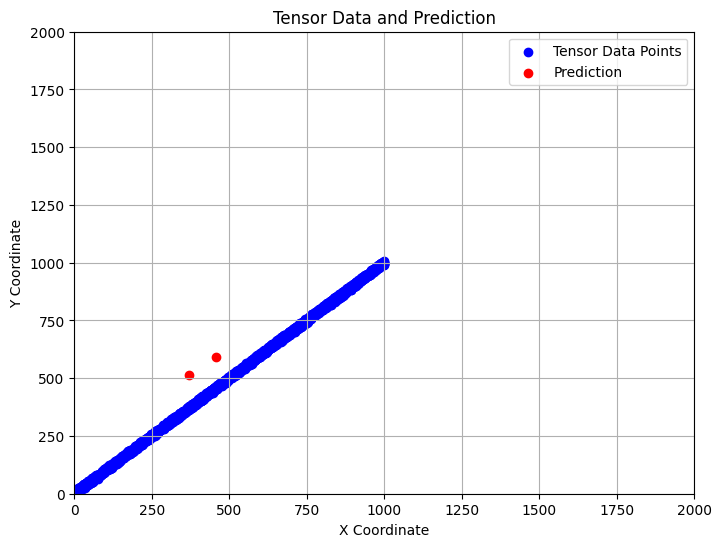

In [14]:
t_src_data_tensor = torch.tensor(t_src_data_tensor)
predictions = torch.tensor(predictions)

# Create a plot for tensors
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], color='blue', label='Tensor Data Points')
plt.scatter(pred[0], pred[1], color='red', label='Prediction')
plt.title('Tensor Data and Prediction')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.xlim(0, 2000)
plt.ylim(0, 2000)
plt.legend()
plt.grid(True)
plt.savefig("straightLine.png")

# Actual Model


In [ ]:
src_data_tensor[:, 0]

/var/folders/gq/k2wksnfs5m34lrrnz62k7lrc0000gn/T/ipykernel_4102/224777830.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_src_data_tensor = torch.tensor(t_src_data_tensor)
/var/folders/gq/k2wksnfs5m34lrrnz62k7lrc0000gn/T/ipykernel_4102/224777830.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(predictions)


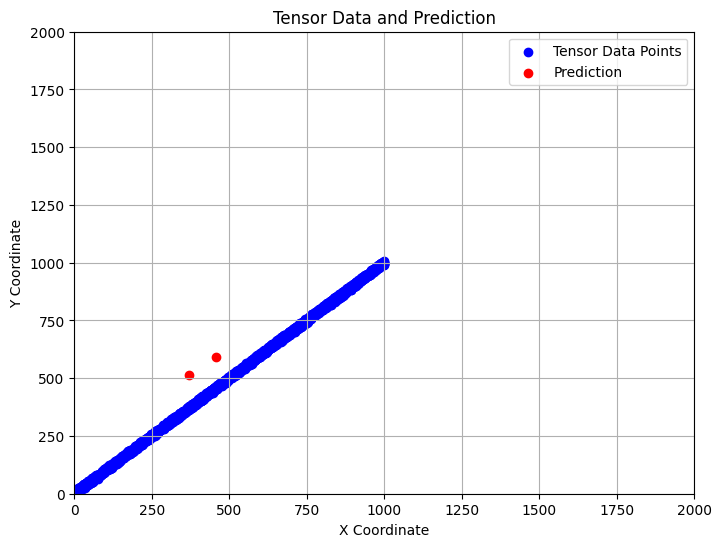

In [15]:
t_src_data_tensor = torch.tensor(t_src_data_tensor)
predictions = torch.tensor(predictions)

# Create a plot for tensors
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], color='blue', label='Tensor Data Points')
plt.scatter(pred[0], pred[1], color='red', label='Prediction')
plt.title('Tensor Data and Prediction')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.xlim(0, 2000)
plt.ylim(0, 2000)
plt.legend()
plt.grid(True)
plt.savefig("straightLine.png")

In [16]:
def plot_syn(random_trajectories=[], pred=[]):
    if(len(random_trajectories) == 0):
        random_trajectories = dm.create_synthetic(3)
    for trajectory in random_trajectories:
        print(trajectory)
        x_values = [point[0] for point in trajectory]
        y_values = [point[1] for point in trajectory] 
        plt.plot(x_values, y_values)
        print("hi")
    plt.scatter(pred[0], pred[1], color='red', label='Prediction')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(0, 2000)
    plt.ylim(0, 2000)
    plt.title('Trajectories')
    plt.grid(True)
    plt.show()

In [ ]:
pred[4][0]

tensor([[288.0000, 850.0000],
        [294.0000, 850.0000],
        [300.0000, 850.0000],
        [306.0000, 850.0000],
        [312.0000, 850.0000],
        [318.0000, 850.0000],
        [330.0000, 850.0000],
        [336.0000, 850.0000],
        [342.0000, 850.0000],
        [348.0000, 850.0000],
        [354.0000, 850.0000],
        [360.0000, 850.0000],
        [366.0000, 850.0000],
        [372.0000, 850.0000],
        [378.0000, 850.0000],
        [384.0000, 850.0000],
        [390.0000, 850.0000],
        [396.0000, 850.0000],
        [402.0000, 850.0000]])
hi


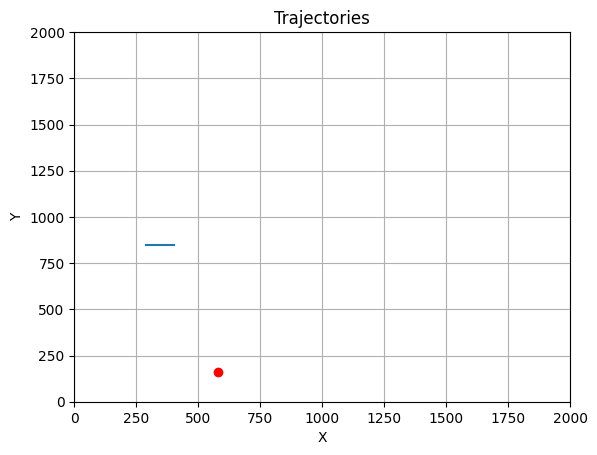

In [17]:
first_ten_arrays = data[3:4]

# Now exclude the element at index 6 from each of these sub-arrays
result_tensor = torch.cat((first_ten_arrays[:, :6], first_ten_arrays[:, 7:]), dim=1)

plot_syn(result_tensor, pred[4])

In [18]:
data[3:4]

tensor([[[ 288.0000,  850.0000],
         [ 294.0000,  850.0000],
         [ 300.0000,  850.0000],
         [ 306.0000,  850.0000],
         [ 312.0000,  850.0000],
         [ 318.0000,  850.0000],
         [-155.9711, -151.1673],
         [ 330.0000,  850.0000],
         [ 336.0000,  850.0000],
         [ 342.0000,  850.0000],
         [ 348.0000,  850.0000],
         [ 354.0000,  850.0000],
         [ 360.0000,  850.0000],
         [ 366.0000,  850.0000],
         [ 372.0000,  850.0000],
         [ 378.0000,  850.0000],
         [ 384.0000,  850.0000],
         [ 390.0000,  850.0000],
         [ 396.0000,  850.0000],
         [ 402.0000,  850.0000]]])

In [19]:
src_data_tensor[:10]

tensor([[[0.8550, 0.4345],
         [0.8601, 0.4345],
         [0.8652, 0.4345],
         [0.8703, 0.4345],
         [0.8754, 0.4345],
         [0.8805, 0.4345],
         [0.0000, 0.0000],
         [0.8907, 0.4345],
         [0.8958, 0.4345],
         [0.9009, 0.4345],
         [0.9060, 0.4345],
         [0.9111, 0.4345],
         [0.9162, 0.4345],
         [0.9213, 0.4345],
         [0.9264, 0.4345],
         [0.9315, 0.4345],
         [0.9366, 0.4345],
         [0.9417, 0.4345],
         [0.9468, 0.4345],
         [0.9519, 0.4345]],

        [[0.6160, 0.5527],
         [0.6159, 0.5534],
         [0.6158, 0.5541],
         [0.6156, 0.5548],
         [0.6155, 0.5556],
         [0.6153, 0.5563],
         [0.0000, 0.0000],
         [0.6151, 0.5578],
         [0.6149, 0.5585],
         [0.6148, 0.5592],
         [0.6146, 0.5600],
         [0.6145, 0.5607],
         [0.6144, 0.5614],
         [0.6142, 0.5621],
         [0.6141, 0.5629],
         [0.6139, 0.5636],
         [0.6138, 0.5643],

In [20]:
def compute_accuracy(predictions, targets, threshold=0.1):
    distances = torch.sqrt(torch.sum((predictions - targets) ** 2, dim=1))
    accurate_predictions = distances < threshold
    accuracy = torch.mean(accurate_predictions.float()) * 100
    return accuracy.item()
predictions = model(t_src_data_tensor)
acc = compute_accuracy(predictions, t_tgt_data_tensor, 0.05)
print('accuracy of model to predict a point: {:.2f} %'.format(acc))

accuracy of model to predict a point: 100.00 %


In [ ]:
t_tgt_data_tensor

In [ ]:
data = unnormalize_data_pred(t_tgt_data_tensor, min_x, min_y, range_x, range_y)
torch.tensor(data)

In [21]:
data = unnormalize_data_pred(t_tgt_data_tensor, min_x, min_y, range_x, range_y)
pred = unnormalize_data_pred(predictions, min_x, min_y, range_x, range_y)
acc = compute_accuracy(torch.tensor(pred), torch.tensor(data), 10)
print('accuracy of model to predict a point: {:.2f} %'.format(acc))

accuracy of model to predict a point: 64.83 %


In [22]:
torch.tensor(x[:1])

NameError: name 'x' is not defined

In [23]:
def plot_syn(random_trajectories=[], pred=[], y=[]):
    if(len(random_trajectories) == 0):
        random_trajectories = dm.create_synthetic(3)
    for trajectory in random_trajectories:
        print(trajectory)
        x_values = [point[0] for point in trajectory]
        y_values = [point[1] for point in trajectory] 
        plt.plot(x_values, y_values)
        print("hi")
    plt.scatter(pred[0], pred[1], color='red', label='Prediction')
    plt.scatter(y[0], y[1], color='blue', label='Actual') 

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(650, 700)
    plt.ylim(650, 700)
    plt.title('Trajectories')
    plt.grid(True)
    plt.legend()
    plt.savefig("straighLine.png")
    plt.show()

In [ ]:
single_point = torch.tensor(y[3]).unsqueeze(0)  # Make it (1, 2)
# Expand this point to match the first dimension of first_ten_arrays
expanded_point = single_point.expand(first_ten_arrays.size(0), -1, -1)  # Expand to (10, 1, 2)

# Concatenate the point between the two segments
result_tensor = torch.cat((first_ten_arrays[:, :6], expanded_point, first_ten_arrays[:, 7:]), dim=1)

print(result_tensor)

In [ ]:
y[3]

In [ ]:
for i in range(200):
  if(np.abs(y[i][0] - y[i][1]) < 100):
    print(i)
    print(y[i])

In [ ]:
x = unnormalize_data(t_src_data_tensor, min_x, min_y, range_x, range_y)
y = unnormalize_data_pred(t_tgt_data_tensor, min_x, min_y, range_x, range_y)

index = 22

print(x[index])
print(pred[index])
print(y[index])
first_ten_arrays = torch.tensor(x[index:index+1])

# Now exclude the element at index 6 from each of these sub-arrays
single_point = torch.tensor(y[index]).unsqueeze(0)  # Make it (1, 2)
# Expand this point to match the first dimension of first_ten_arrays
expanded_point = single_point.expand(first_ten_arrays.size(0), -1, -1)  # Expand to (10, 1, 2)

# Concatenate the point between the two segments
result_tensor = torch.cat((first_ten_arrays[:, :6], expanded_point, first_ten_arrays[:, 7:]), dim=1)
              
plot_syn(result_tensor, torch.tensor(pred[index]),  torch.tensor(y[index]))

In [ ]:
torch.tensor(x[:1])

In [ ]:
print(t_tgt_data_tensor[0])
print(predictions[0])

In [ ]:
(0 * range_x + min_x)

In [ ]:
def normalize_data(data, min_x=0, min_y=0, range_x=0, range_y=0):
    # (x, y) -> needs to be the data, otherwise i gotta rewrite possibly
    # can assume with none
    all_points = [point for seq in data for point in seq if point is not None]
    if range_x or range_y == 0 or min_x == 0 or min_y == 0:
        all_x = [point[0] for point in all_points]
        all_y = [point[1] for point in all_points] 

        min_x = min(all_x)
        max_x = max(all_x)
        min_y = min(all_y)
        max_y = max(all_y)
        range_x = max_x - min_x
        range_y = max_y - min_y
        print(min_x)

    # Normalize data
    normalized_data = []
    for seq in data:
        normalized_seq = [(float(point[0] - min_x) / range_x, float(point[1] - min_y) / range_y) if point is not None else None for point in seq]
        normalized_data.append(normalized_seq)

    return normalized_data, min_x, min_y, range_x, range_y

train, min_x, min_y, range_x, range_y = normalize_data(train_norm)

In [ ]:
all_points = [point for seq in train_norm for point in seq if point is not None]

all_x = [point[0] for point in all_points]
all_y = [point[1] for point in all_points] 

print(min(all_x))
m = min(all_y)
for ele in all_points:
  if ele[1] == m:
    print(ele)
# print(len(train_norm))